# DEOCSU - DEep-learning Optimized ChIP-exo peak calling SUite

## <span style="color:blue"> Environmental setup </span>

## Prerequisite
0. python 3 (https://www.python.org/)
--------------------------------------
Download the python package using
- anaconda : https://anaconda.org/
- pip : https://pypi.org/
--------------------------------------
1. pandas (https://pandas.pydata.org/)
2. cv2 (https://opencv.org/)
3. matplotlib (https://matplotlib.org/)
4. tensorflow (https://www.tensorflow.org/)<br>
    -keras (https://keras.io/)<br>
    -scipy (https://scipy.org/)<br>
    -numpy (https://numpy.org/)<br>
5. statsmodels (https://www.statsmodels.org/)
6. sklearn (https://scikit-learn.org/)
7. Biopython (https://biopython.org/)
8. pysam (https://github.com/pysam-developers/pysam)

# ================================

In [1]:
import os,sys,time, itertools, pysam, math, getpass

import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import tensorflow as tf 
import scipy.stats as stats
import statsmodels.api as sm

from Bio import SeqIO
from numpy import zeros
from sklearn.model_selection import train_test_split
from scipy.signal import chirp, find_peaks, peak_widths
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils

from tensorflow.keras.utils import plot_model
from tensorflow.python.keras.models import load_model

# Input file

1. Download the genbank(full) format reference file from NCBI database
>https://www.ncbi.nlm.nih.gov/



2. BAM format file 
>BAM file must be sorted and indexed using samtools.

# <span style="color:red"> ↓↓ Please change the directory of the input file ↓↓ </span>

In [2]:
#Output directory
dir_notebook = "/home/ina/DEOCSU-test/"
dir_model = "/home/ina/DEOCSU-test/DEOCSU_model.h5"

#Input file directory
dir_reference = dir_notebook + "Input/NC_000913.gb" #NCBI genbank(full) file
dir_bam1 = dir_notebook + "Input/cra-acetate-1.bam" #replicate 1
dir_bam2 = dir_notebook + "Input/cra-acetate-2.bam" #replicate 2(If it doesn't exist, write the same as dir_bam1)

#Output file name
output_name = "cra-acetate"

# Probability cut-off(0.5 ~ 1.0) default == 0.8
cut_off = 0.8

# Running the code [Please do not change the code]

In [3]:
os.chdir(dir_notebook)
!mkdir "DEOCSU_temp" "DEOCSU_output"
dir_temp = dir_notebook + "DEOCSU_temp/"
dir_output = dir_notebook + "DEOCSU_output/"

###########################################If a permission denied error occurs, run this cell instead of the cell above.
"""
print ("Write your admin password :")
os.chdir(dir_notebook)
command = "sudo mkdir \"DEOCSU_temp\" \"DEOCSU_output\""
!echo {getpass.getpass()} | sudo -S {command}
"""
###########################################

#Making the reference files
dic_len = {}
ref_info = ".".join(dir_reference.split("/")[-1].split(".")[:-1])

with open("%sAnnotation_%s.gff"%(dir_output, ref_info), "w") as f_rgff:
    genomes = SeqIO.parse( dir_reference, "genbank")
    for genome in genomes:
        #Chromosome size
        dic_len[ genome.id ] = int(len(genome.seq))
        
        #Annotation file for metascope (.gff)
        dic_info = {}
        for gene in genome.features:
            if gene.type == "CDS":
                cds_locus =  gene.qualifiers.get("locus_tag")[0]
                cds_product, cds_protein = "-", "-"
                if gene.qualifiers.get("product") != None:
                    cds_product = gene.qualifiers.get("product")[0]
                if gene.qualifiers.get("protein_id") != None:
                    cds_protein_id = gene.qualifiers.get("protein_id")[0]

                if cds_locus in dic_info.keys():
                    cds_w2 = "Other_info;protein_id=%s;product=%s;color=000000;"%(cds_protein_id, cds_product)
                    new_info = dic_info[ cds_locus ].replace( "color=00A500;", cds_w2 )
                    dic_info[ cds_locus ] = new_info

                else:
                    cds_w = "type=CDS;protein_id=%s;product=%s;color=00A500;"%(cds_protein_id, cds_product)
                    dic_info[ cds_locus ] = cds_w

            elif gene.type in ['rRNA','tRNA','ncRNA','tmRNA'] :
                rna_locus = gene.qualifiers.get("locus_tag")[0]
                rna_product = "-"
                if gene.qualifiers.get("product") != None:
                    rna_product = gene.qualifiers.get("product")[0]

                if rna_locus in dic_info.keys():
                    rna_w2 = "Other_info;product=%s;color=000000;"%( rna_product )
                    newinfo = dic_info[ rna_locus ].replace( "color=FF0000;", rna_w2 )
                    dic_info[ rna_locus ] = newinfo

                else:
                    rna_w = "type=%s;product=%s;color=FF0000;"%( gene.type, rna_product )
                    dic_info[ rna_locus ] = rna_w

        #write_gff
        for gene in genome.features:
            if gene.type == "gene":
                gene_locus = gene.qualifiers.get("locus_tag")[0]
                if gene.qualifiers.get("gene") != None:
                    gene_name = gene.qualifiers.get("gene")[0]
                if gene.qualifiers.get("gene_synonym") != None:
                    syn = gene.qualifiers.get("gene_synonym")[0].split("; ")
                    gene_name += ",%s"%(",".join(syn))
                else: gene_name = "-"
                start = str(gene.location.start +1)
                end = str(gene.location.end)
                if gene.strand == 1: strand = "+"
                elif gene.strand == -1: strand = "-"
                else: print ("===========================Gene_Strand information is weird!!! %s"%gene.strand)
                if gene_locus in dic_info.keys():
                    add_info = dic_info[gene_locus]
                else: 
                    add_info = "color=000000;"
                attr = "gene=%s;locus_tag=%s;%s"%(gene_name, gene_locus,add_info)
                gff_w = [ genome.id, "NCBI","NCBI", start, end, ".", strand, ".", attr ] 
                f_rgff.write( "\t".join(gff_w) + "\n")

            elif gene.type == "regulatory":
                start = str(gene.location.start +1)
                end = str(gene.location.end)
                if gene.strand == 1: strand = "+"
                elif gene.strand == -1: strand = "-"
                else: print ("===========================Regulatory_Strand information is weird!!! %s"%gene.strand)
                attr = "type=regulatory;color=0000FF;"
                gff_w = [ genome.id, "NCBI","NCBI", start, end, ".", strand, ".", attr ]
                f_rgff.write( "\t".join(gff_w) + "\n")

            elif gene.type == "repeat_region":
                start = str(gene.location.start +1)
                end = str(gene.location.end)
                if gene.strand == 1: strand = "+"
                elif gene.strand == -1: strand = "-"
                else: print ("===========================repeat_region_Strand information is weird!!! %s"%gene.strand)
                attr = "type=repeat_region;color=808080;"
                gff_w = [ genome.id, "NCBI","NCBI", start, end, ".", strand, ".", attr ]
                f_rgff.write( "\t".join(gff_w) + "\n") 
print ("Making the reference files - Done ฅ^•ﻌ•^ฅ")

#Makegff
def count_coverage(samfile, chromosome_size=8000000, flip=False):
    """counts coverage per base in a strand-specific manner

    For paired-end reads, the insert between the mapped reads is
    also counted.

    flip: Whether or not the strands should be flipped.
    This should be true for RNA-seq, and false for ChIP-exo

    chromsome_size: This value should be larger than the largest chromosome"""
    all_counts = {}
    plus_strands = []
    minus_strands = []
    if "SQ" in samfile.header:
        chromosome_sizes = {}
        for entry in samfile.header["SQ"]:
            chromosome_sizes[entry["SN"]] = int(entry["LN"]) + 1
    else:
        for reference in samfile.references:
            chromosome_sizes[reference] = chromosome_size
    for reference in samfile.references:  # create an array for each reference
        plus_strands.append(zeros((chromosome_sizes[reference],)))
        minus_strands.append(zeros((chromosome_sizes[reference],)))
    # iterate through each mapped read
    for i, read in enumerate(samfile):
        if read.is_unmapped:
            continue
        if not read.is_proper_pair:
            if read.is_reverse:
                minus_strands[read.tid][read.pos:read.aend] += 1
            else:
                plus_strands[read.tid][read.pos:read.aend] += 1
        # for paired-end data, get entire insert from only read1
        elif read.is_read1:
            if read.is_reverse:
                minus_strands[read.tid][read.pnext:read.aend] += 1
            else:
                plus_strands[read.tid][read.pos:read.pos + read.isize] += 1
    # store the results per reference
    for i, reference in enumerate(samfile.references):
        all_counts[reference] = {}
        if flip:
            all_counts[reference]["-"] = plus_strands[i]
            all_counts[reference]["+"] = minus_strands[i]
        else:
            all_counts[reference]["+"] = plus_strands[i]
            all_counts[reference]["-"] = minus_strands[i]
    return all_counts

def count_coverage_indexed(samfile, chromosome_size=8000000, flip=False):
    """counts coverage per base in a strand-specific manner

    For paired-end reads, the insert between the mapped reads is
    also counted.

    flip: Whether or not the strands should be flipped.
    This should be true for RNA-seq, and false for ChIP-exo

    chromsome_size: This value should be larger than the largest chromosome"""
    if "SQ" in samfile.header:
        chromosome_sizes = {}
        for entry in samfile.header["SQ"]:
            chromosome_sizes[entry["SN"]] = int(entry["LN"]) + 1
    else:
        for reference in samfile.references:
            chromosome_sizes[reference] = chromosome_size
    all_counts = {}
    for reference in samfile.references:  # go through each chromosome
        plus_strand = zeros((chromosome_sizes[reference],))
        minus_strand = zeros((chromosome_sizes[reference],))
        # iterate through each mapped read
        for i, read in enumerate(samfile.fetch(reference=reference)):
            if not read.is_proper_pair:
                if read.is_reverse:
                    minus_strand[read.pos:read.aend] += 1
                else:
                    plus_strand[read.pos:read.aend] += 1
            # for paired-end data, get entire insert from only read1
            elif read.is_read1:
                if read.is_reverse:
                    minus_strand[read.pnext:read.aend] += 1
                else:
                    plus_strand[read.pos:read.pos + read.isize] += 1
            all_counts[reference] = {}
            if flip:
                all_counts[reference]["-"] = plus_strand
                all_counts[reference]["+"] = minus_strand
            else:
                all_counts[reference]["+"] = plus_strand
                all_counts[reference]["-"] = minus_strand
    return all_counts


def write_samfile_to_gff(samfile, output, chromosome_size=8000000, separate_strand=True, flip=False, log_scale=False):
    """write samfile object to an output object in a gff format

    flip: Whether or not the strands should be flipped.
    This should be true for RNA-seq, and false for ChIP-exo

    chromsome_size: This value should be larger than the largest chromosome

    separate_strand: Whether the forward and reverse strands should be made
    into separate tracks (True) or the negative strand should be rendered
    as negative values (False)
    """
    all_counts = count_coverage(samfile, chromosome_size=chromosome_size,flip=flip)
    name = os.path.split(samfile.filename)[1]
    for reference in all_counts:
        for strand in all_counts[reference]:
            counts = all_counts[reference][strand]
            for i in counts.nonzero()[0]:
                if log_scale:
                    count = math.log(float(counts[i]), 2)
                else:
                    count = counts[i]
                if separate_strand:
                    output.write("%s\t\t%s\t%d\t%d\t%.2f\t%s\t.\t.\n" %
                        (reference, "%s_(%s)" %(name.decode('ascii'), strand), i, i,count, strand))
                else:
                    output.write("%s\t\t%s\t%d\t%d\t%.2f\t%s\t.\t.\n" %
                        (reference, name.decode('ascii'), i, i, count,strand))


def convert_samfile_to_gff(sam_filename, out_filename, chromosome_size=8000000,separate_strand=True, flip=False, log_scale=False):
    """read in the a samfile from a path, and write it out to a gff filepath

    flip: Whether or not the strands should be flipped.
    This should be true for RNA-seq, and false for ChIP-exo.

    chromsome_size: This value should be larger than the largest chromosome.

    separate_strand: Whether the forward and reverse strands should be made
    into separate tracks (True) or the negative strand should be rendered
    as negative values (False)
    """
    samfile = pysam.Samfile(sam_filename)
    with open(out_filename, "w") as outfile:
        write_samfile_to_gff(samfile, outfile, chromosome_size=chromosome_size, separate_strand=separate_strand, flip=flip, log_scale=log_scale)
    samfile.close()

dir_R1 = dir_output + dir_bam1.split("/")[-1].split(".bam")[0] + ".gff"
dir_R2 = dir_output + dir_bam2.split("/")[-1].split(".bam")[0] + ".gff"

convert_samfile_to_gff( dir_bam1, dir_R1 )
convert_samfile_to_gff( dir_bam2, dir_R2 )
print ("Makegff - Done ฅ^•ﻌ•^ฅ")

dic_R1, dic_R2 = {}, {}

with open( dir_R1, "r" ) as R1 :
    r1 = R1.read().split("\n")
    for line in r1:
        if line == "": continue
        line = line.split("\t")
        a_num = line[0]
        strand = line[6]
        start = int(line[3])
        score = float( line[5] )
        dkey = a_num + "-%s"%str(start)

        if "+" in strand:
            if dkey in dic_R1.keys():
                dic_R1[ dkey ][0] = score
            else:            
                dic_R1[ dkey ] = [ score, 0 ]
                
        elif "-" in strand :
            if dkey in dic_R1.keys():
                dic_R1[ dkey ][1] = score
            else:
                dic_R1[ dkey ] = [ 0, score ]

with open( dir_R2, "r" ) as R2 :
    r2 = R2.read().split("\n")
    for line in r2:
        if line == "": continue
        line = line.split("\t")
        a_num = line[0]
        strand = line[6]
        start = int(line[3])
        score = float( line[5] )
        dkey = a_num + "-%s"%str(start)

        if "+" in strand:
            if dkey in dic_R2.keys():
                dic_R2[ dkey ][0] = score
            else:            
                dic_R2[ dkey ] = [ score, 0 ]
                
        elif "-" in strand :
            if dkey in dic_R2.keys():
                dic_R2[ dkey ][1] = score
            else:
                dic_R2[ dkey ] = [ 0, score ]
                
dir_raw_csv = dir_temp + output_name + "_raw.csv"
with open( dir_raw_csv, "w") as final :
    final.write( "location,1_plus,1_minus,2_plus,2_minus\n" )
    
    genomes = list(dic_len.keys())
    for genome in genomes:
        acce = genome
        for x in range( 1 , int(dic_len[genome])+1 ):
            key = acce + "-%s"%str(x)
            d1_plus, d1_minus, d2_plus, d2_minus = "0","0","0","0"
            
            if key in dic_R1.keys():
                d1_plus = str(dic_R1[key][0])
                d1_minus = str(dic_R1[key][1])
            
            if key in dic_R2.keys():
                d2_plus = str(dic_R2[key][0])
                d2_minus = str(dic_R2[key][1])
            
            w = [ key, d1_plus, d1_minus, d2_plus, d2_minus ]
            final.write( ",".join(w) + "\n")
dic_R1, dic_R2 = {}, {}
print ("Temp file - Done ฅ^•ﻌ•^ฅ")

#Peak detection
dir_peak_csv = dir_temp + output_name + "_detected_peak.csv"
d1 = pd.read_csv(dir_raw_csv)
d_list = [ d1 ]
t_list = [ output_name ]

for cnt in range(len(d_list)):
    print(t_list[cnt])
    d = d_list[cnt]
    target = d['1_plus']
    i = 0
    peak_x2_list = []

    while True:
        t = target[i : i + 10000]
        peak_x, properties = find_peaks(t, threshold = 0.0, distance = 400, rel_height = 0.2)
        peak_x2 = [j + i for j in peak_x]
        peak_x2_list = peak_x2_list + peak_x2

        i = i + 10000

        if i > len(target):
            break
            
    loc_list = []
    raw = d['location'].tolist()
    for i in peak_x2_list:
        loc = raw[i] # peak_x2_list
        loc_list.append(loc)
        
    df_peak = pd.DataFrame({})
    df_peak['location'] = loc_list
    print("Detected raw peak = %d"%len(loc_list))
    
    df_peak.to_csv( dir_peak_csv )
print ("Peak detection - Done ฅ^•ﻌ•^ฅ")

#Making 256 window
dir_4duc = dir_temp + output_name + "_4duc.tsv"
with open(dir_raw_csv, "r") as csv,open(dir_peak_csv, "r") as peak,open(dir_4duc, "w") as final:
    w_info = ['location', "S1_plus", "S1_minus", "S2_plus", "S2_minus"]
    final.write("\t".join(w_info)+"\n")
    #===========================================
    dic_csv = {}
    clines = csv.read().split("\n")
    for cline in clines:
        cline = cline.split(",")
        dic_csv[cline[0]] = cline[1:]
    #===========================================
    plines = peak.read().split("\n")
    for pline in plines[1:(len(plines)-1)]:
        pline = pline.split(",")
        acc_loc = pline[1]
        #print(acc_loc)
        acc = acc_loc.split("-")[0]
        peak = int(acc_loc.split("-")[1])

        d1_plus, d1_minus, d2_plus, d2_minus = [],[],[],[]

        if peak <= 128:
            range_info = range(1, peak+128)
        elif peak > (dic_len[acc]-128):
            range_info = range(peak-128, dic_len[acc])
        else:
            range_info = range(peak-128, peak+128)

        for p in range_info :
            loc = "%s-%d"%(acc,p)
            lst_score = dic_csv[str(loc)]

            d1_plus.append(float(lst_score[0]))
            d1_minus.append(float(lst_score[1]))
            d2_plus.append(float(lst_score[2]))
            d2_minus.append(float(lst_score[3]))


        w = [acc_loc, str(d1_plus), str(d1_minus), str(d2_plus), str(d2_minus)]
        final.write("\t".join(w)+ "\n")

    print ("Making window - Done ฅ^•ﻌ•^ฅ")
    
#Data processing
df = pd.read_csv(dir_4duc, sep="\t")

model = load_model(dir_model)

S1_p = [eval(i) for i in df['S1_plus'].tolist()]
S1_m = [eval(i) for i in df['S1_minus'].tolist()]
S2_p = [eval(i) for i in df['S2_plus'].tolist()]
S2_m = [eval(i) for i in df['S2_minus'].tolist()]

scaler = MinMaxScaler()
rgba_list = []
for i in range(len(S1_p)):
    r = scaler.fit_transform(np.array(S1_p[i]).reshape(-1,1)).reshape(1,-1).tolist()[0]
    g = scaler.fit_transform(np.array(S1_m[i]).reshape(-1,1)).reshape(1,-1).tolist()[0]
    b = scaler.fit_transform(np.array(S2_p[i]).reshape(-1,1)).reshape(1,-1).tolist()[0]
    a = scaler.fit_transform(np.array(S2_m[i]).reshape(-1,1)).reshape(1,-1).tolist()[0]
    rgba = np.array([r,g,b,a]).T
    rgba_list.append(rgba.tolist())
    
df['img_raw'] = rgba_list

rgba_list_resized = []
for i in rgba_list :
    resized = cv.resize(np.array(i), dsize = (4,256), interpolation  = cv.INTER_AREA)
    rgba_list_resized.append(resized.tolist())
df['resized_img'] = rgba_list_resized
#===========================================
#Calculation wodth and Peak lication correction
X = np.array([i for i in df['resized_img'].tolist()])

X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
X = X.astype('float32')/255.0

predict = model.predict(X)
predict_labels = np.argmax(predict, axis = 1)
predict_t = np.array(predict).T[1]

df['predicted'] = predict_t
df['predicted_label'] = predict_labels

ans = df['predicted_label'].tolist()
pr = np.array( [ i for i in df['predicted'].tolist() ])

df['ans'] = ans
df['pr'] = pr

df_T = df[df['ans'] == 1]
df = df[df['predicted_label'] == 1]
sp1 = [eval(j) for j in df_T['S1_plus'].tolist()]
sm1 = [eval(j) for j in df_T['S1_minus'].tolist()]
sp2 = [eval(j) for j in df_T['S2_plus'].tolist()]
sm2 = [eval(j) for j in df_T['S2_minus'].tolist()]

def differen(data):
    a = data.index(max(data))
    b = data.index(min(data))
    ans = np.abs(a-b)
    return ans

def Index(data):
    a = data.index(max(data))
    b = data.index(min(data))
    #ans = np.abs(a-b)
    return a,b

x1_l = []
x2_l = []
for i in range(len(df_T)):
    d1 = np.diff(sp1[i]).tolist()
    d2 = np.diff(sm1[i]).tolist()
    d3 = np.diff(sp2[i]).tolist()
    d4 = np.diff(sm2[i]).tolist()
    
    a1, b1 = Index(d1)
    a2, b2 = Index(d2)
    a3, b3 = Index(d3)
    a4, b4 = Index(d4)
    max_mean = np.mean([a1,a2, a3, a4])
    min_mean = np.mean([ b1, b2, b3, b4])

    x1_l.append(max_mean)
    x2_l.append(min_mean)
    
re_l = [np.abs(x1_l[i] - x2_l[i]) for i in range(len(x1_l))]
    
df['x1'] = x1_l
df['x2'] = x2_l
df['width'] = re_l

dir_final_tsv = dir_temp + output_name + "_final.tsv"
df.to_csv( dir_final_tsv, columns = ['location', 'predicted_label', 'predicted', 'width', 'x1', 'x2'], index=False, sep="\t")
print ("Data processing - Done ฅ^•ﻌ•^ฅ")

#make peak gff
T_result = dir_output + output_name + "_DEOCSU.gff"
T_result_cut = dir_output + output_name + "_DEOCSU_%s.gff"%cut_off

lst_line, lst_width = [], []
with open(dir_final_tsv, "r") as fre, open(T_result, "w") as final_T, open( T_result_cut, "w" ) as final_cut :
    lines = fre.readlines()
    
    for line in lines[1:]:
        peak_info = line.split("\t")
        
        true_ori = float(peak_info[2])
        true_perc = "Probability_of_true=%.2f%%;"%(true_ori*100)

        acc = peak_info[0].split("-")[0]
        loc = int(peak_info[0].split("-")[1])
        label = peak_info[1]
        lst_width.append(float(peak_info[3]))

        x = [ float(peak_info[4]), float(peak_info[5]) ]

        start = loc - 128 + int(round( float( min(x) ) ))
        end = loc - 128 + int(round( float( max(x) ) ))

        if end <0 :
            continue
        elif start < 0 :
            start = 0

        new_info = "%s-%d"%(acc,start)

        if new_info in lst_line:
            continue

        elif label == "1":
            attr = "True;%s;color=FF0000"%true_perc
            w = [ acc, "DEOCSU_%s"%output_name, "DEOCSU_%s"%output_name, str(start), str(end), ".", "+", ".", attr ]
            final_T.write("\t".join(w) + "\n")

            if true_ori >= cut_off :
                w2 = [ acc, "DEOCSU_%s[%s]"%(output_name,cut_off), "DEOCSU_%s[%s]"%(output_name,cut_off), str(start), str(end), ".", "+", ".", attr ]
                final_cut.write("\t".join(w2) + "\n")

            lst_line.append(new_info)

        else:
            print ("Error : Label is not True ---- %s"%(acc + "-" + str(loc)))
print ("Make peak gff - Done ฅ^•ﻌ•^ฅ")

!rm -r $dir_temp

# Post DEOCSU

<function matplotlib.pyplot.show(close=None, block=None)>

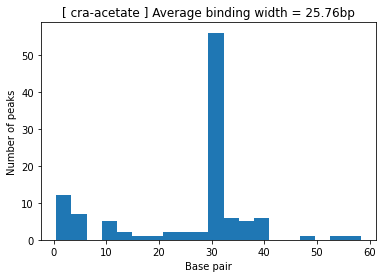

In [12]:
#Check Width histogram
npw =np.array(lst_width)

plt.hist(lst_width, bins=20)
plt.xlabel('Base pair')
plt.ylabel('Number of peaks')

plt.title( "[ %s ] \n Average binding width = %.2fbp"%(output_name, np.mean(npw)) )
plt.savefig( dir_output + output_name + ".png" )
plt.show